In [1]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import (
    get_city_coordinates, get_island_coordinates, 
    get_orthogonal_samples)
from image_ops import flood_image
from skimage.segmentation import flood, flood_fill


import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

import ipywidgets as widgets
from IPython.display import display
import glob

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
realm_selection = widgets.Dropdown(
    options=glob.glob("../svgs/*.svg"),
    description='svg:',
    disabled=False,
)
display(realm_selection)

Dropdown(description='svg:', options=('../svgs/6316.svg', '../svgs/4425.svg', '../svgs/7065.svg', '../svgs/133…

In [3]:
def filter_within_bounds(coordinates, width, height):
    filtered_centers = []
    for co in coordinates:
        if 0 <= co[0] < width and 0 <= co[1] < height:
            filtered_centers.append(co)
        else:
            logging.warning(f"out of bounds coordinate!: {co}")
    return filtered_centers

def generate_terrain(
    mask,
    disc_radius=4.,
    max_delta=0.05,
    river_downcutting_constant=1.3,
    directional_inertia=0.1,
    default_water_level=1.0,
    evaporation_rate=0.1,
    coastal_dropoff=50., # high: very small slope towards sea, low: abrupt change to sea
    mountain_sigma=1.0,
    lakes_alpha=0.1
):
    dim = mask.shape[0]
    shape = (dim,) * 2
    print('  ...initial terrain shape')
    land_mask = remove_lakes(
      (util.fbm(shape, -2, lower=2.0) + bump(shape, 0.2 * dim) - lakes_alpha) > 0)
    land_mask = mask > 0
    coastal_dropoff = np.tanh(util.dist_to_mask(land_mask) / coastal_dropoff) * land_mask
    mountain_shapes = util.fbm(shape, -2, lower=2.0, upper=np.inf)
    initial_height = ( 
      (util.gaussian_blur(np.maximum(mountain_shapes - 0.4, 0.0), sigma=mountain_sigma) 
        + 0.1) * coastal_dropoff)
    deltas = util.normalize(np.abs(util.gaussian_gradient(initial_height))) 

    print('  ...sampling points')
    points = util.poisson_disc_sampling(shape, disc_radius)
    coords = np.floor(points).astype(int)

    print('  ...delaunay triangulation')
    tri = sp.spatial.Delaunay(points)
    (indices, indptr) = tri.vertex_neighbor_vertices
    neighbors = [indptr[indices[k]:indices[k + 1]] for k in range(len(points))]
    points_land = land_mask[coords[:, 0], coords[:, 1]]
    points_deltas = deltas[coords[:, 0], coords[:, 1]]

    print('  ...initial height map')
    points_height = compute_height(points, neighbors, points_deltas)

    print('  ...river network')
    (upstream, downstream, volume) = compute_river_network(
      points, neighbors, points_height, points_land,
      directional_inertia, default_water_level, evaporation_rate)

    print('  ...final terrain height')
    new_height = compute_final_height(
      points, neighbors, points_deltas, volume, upstream, 
      max_delta, river_downcutting_constant)
    return render_triangulation(shape, tri, new_height)

def run_pipeline(realm_path, config, debug=True):
    # set some often-used parameters
    svgp = config.svg.padding
    debug_img_size = (10,10)
    
    realm_number = realm_path.split("/")[-1][:-4]
    logging.info(f"Processing realm number: {realm_number}")
    
    logger.setLevel(logging.INFO)
    logger.info("Setting up extractor")
    extractor = SVGExtractor(realm_path, scale=config.svg.scaling)
    logger.info("\___Done")
    if debug:
        extractor.show(debug_img_size)
        
    logger.info("Extracting coast")
    coast_drawing = extractor.coast()
    coast_img = extractor.get_img()
    logger.info("\___Done")
    
    #############################################
    # MASKING
    #############################################
    
    logger.info("Starting ground-sea mask logic")
    
    logger.info("----Calculating island centers")
    island_centers = get_island_coordinates(
        coast_drawing,
        scaling=config.svg.scaling
    )
    logger.info("    \___Done")
    
    logger.info("----Extracting city centers")
    city_drawing = extractor.cities()
    city_centers = get_city_coordinates(
        city_drawing,
        scaling=config.svg.scaling
    )
    logger.info("    \___Done")
    
    # some small checks
    logger.info("----Filtering centers")
    logger.info("--------Filtering island centers")
    island_centers = filter_within_bounds(island_centers, coast_drawing.width, coast_drawing.height)
    logger.info("        \___Done")
    logger.info("--------Filtering city centers")
    city_centers = filter_within_bounds(city_centers, city_drawing.width, city_drawing.height)
    logger.info("        \___Done")
    
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("coast image with island centers (red) and city centers (green)")
        plt.imshow(coast_img)
        for center in island_centers:
            plt.plot(center[1], center[0], 'ro')
        for center in city_centers:
            plt.plot(center[1], center[0], 'go')
            
    logger.info("----Cropping and flooding areas")
    flooded_image = flood_image(
        coast_img,
        [*city_centers, *island_centers], 
        config.svg.padding
    )
    logger.info("    \___Done")
    
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("Cropped and flooded image")
        plt.imshow(flooded_image)
        plt.show()

    logger.info("----Refining flooded image")
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("sampling locations for refining mask + found centers")
        plt.imshow(flooded_image)
        
    refined_flooded_image = flooded_image.copy()
        
    for path_group in coast_drawing.contents[0].contents:
        path = path_group.contents[0]
        samples1, samples2 = get_orthogonal_samples(path, scaling=config.svg.scaling)
        samples1, samples2 = np.vstack(samples1), np.vstack(samples2)
            
        aggr = []
        for (s1, s2) in zip(samples1, samples2):
            x1, y1 = int(s1[0]-svgp), int(s1[1]-svgp)
            x2, y2 = int(s2[0]-svgp), int(s2[1]-svgp)
            # only add colors if BOTH orthogonals are within bounds
            if 0 <= x1 < flooded_image.shape[0] and 0 <= y1 < flooded_image.shape[1]:
                if 0 <= x2 < flooded_image.shape[0] and 0 <= y2 < flooded_image.shape[1]:
                    aggr.append((flooded_image[y1,x1], flooded_image[y2,x2]))

        if len(aggr) > 3:
            aggr = np.vstack(aggr)
            aggr = np.mean(np.abs(aggr[:,0]-aggr[:,1]))
            if aggr < 10:
                center = np.mean(samples1-svgp, axis=0)
                center = np.clip(center, 0, flooded_image.shape[0]-1)
                refined_flooded_image = flood_fill(
                    refined_flooded_image,
                    (int(center[1]), int(center[0])),
                    0)
                if debug:
                    plt.plot(center[0], center[1], 'go', markersize=5)
        if debug:
            plt.plot(samples1[:,0]-svgp, samples1[:,1]-svgp, 'ro', markersize=1)
            plt.plot(samples2[:,0]-svgp, samples2[:,1]-svgp, 'ro', markersize=1)
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("refined flooded image")
        plt.imshow(refined_flooded_image)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Extracting rivers")
    extractor.rivers()
    rivers = np.asarray(extractor.get_img())[svgp:-svgp,svgp:-svgp,0] # rivers is now [0,255]

    rivers = skimage.filters.gaussian(rivers, sigma=1.5) # rivers is now [0,1]
    rivers = (rivers < 0.99)*255
    
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("rivers")
        plt.imshow(rivers)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Extracting rivers")
    final_mask = (np.logical_or(flooded_image, rivers)-1)*-255
    anti_final_mask = final_mask*-1+255
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("final water")
        plt.imshow(final_mask)
        plt.show()
    logger.info("    \___Done")
    
    #############################################
    # GENERATION
    #############################################

    logger.info("----Terrain generation")
    wpad = config.terrain.water_padding
    wp = np.zeros(
        (final_mask.shape[0]+2*wpad,
         final_mask.shape[1]+2*wpad))
    wp[wpad:-wpad,wpad:-wpad] = final_mask
    final_mask=wp
    terrain_height = generate_terrain(final_mask)
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("terrain height")
        plt.imshow(terrain_height)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Underwater generation")
    wpad = config.terrain.water_padding
    wp = np.ones(
        (anti_final_mask.shape[0]+2*wpad,
         anti_final_mask.shape[1]+2*wpad))*255
    wp[wpad:-wpad,wpad:-wpad] = anti_final_mask
    anti_final_mask=wp
    water_depth = generate_terrain(anti_final_mask)
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("water depth")
        plt.imshow(water_depth)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Combining terrain and water heights")
    m1 = final_mask[wpad:-wpad,wpad:-wpad]
    _m1 = m1 < 255
    m2 = terrain_height[wpad:-wpad,wpad:-wpad]
    m3 = water_depth[wpad:-wpad,wpad:-wpad]
    combined = m2 - 0.2*_m1*m3
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("combined map")
        plt.imshow(combined)
        plt.show()
    logger.info("    \___Done")
    
    #############################################
    # EXPORT 1
    #############################################
    
    logger.info("Exporting height map")
    qmap = (combined-combined.min())/(combined.max()-combined.min())
    qmap = (qmap*255).astype(np.uint8)
    qimg = PIL.Image.fromarray(qmap).convert('L')
    qimg = qimg.resize(
        (config.export.size, config.export.size),
        PIL.Image.NEAREST
    )
    qimg.save(f"../output/height_{realm_number}.png")
    logger.info("\___Done")
    
    #############################################
    # COLORING
    #############################################
    
    logger.info("Coloring")
    plt.hist(combined.flatten(), bins=50)[2]
    def get_color(height):
        if height > .7:
            return np.array([230, 230, 230]) #white
        if height > .5:
            return np.array([158, 158, 158]) #grey
        if height > .4:
            return np.array([120, 174, 106]) #green
        if height > .23:
            return np.array([120, 154, 106]) #green
        if height > .15:
            return np.array([100,  100,  76]) #brown
        if height > .0:
            return np.array([100,  76,  76]) #brown
        return np.array([  20,   50, 160]) #blue

    colorqmap = np.zeros((*combined.shape, 3))
    
    extractor.rivers()
    rivers = np.asarray(extractor.get_img())[svgp:-svgp,svgp:-svgp,0]
    rivers = (rivers<255)*1
#     sea_level = water_level_1+water_level_2
    for x in range(combined.shape[0]):
        for y in range(combined.shape[1]):
            colorqmap[x,y,:] = get_color(combined[x,y])
            if rivers[x, y] > 0:
                colorqmap[x,y,:] = np.array([  20,   50, 160])
    if debug:
        plt.imshow(colorqmap/255)
        plt.show()
    logger.info("\___Done")
    
    #############################################
    # EXPORT 2
    #############################################
    
    logger.info("Exporting color map")
    colorqmap_export = colorqmap.astype(np.uint8)
    colorqmap_export = PIL.Image.fromarray(colorqmap_export)
    colorqmap_export = colorqmap_export.resize(
        (config.export.size, config.export.size),
        PIL.Image.NEAREST
    )
    colorqmap_export.save(f"../output/color_{realm_number}.png")
    logger.info("\___Done")

INFO:root:Processing realm number: 6316
INFO:root:Setting up extractor
INFO:root:\___Done


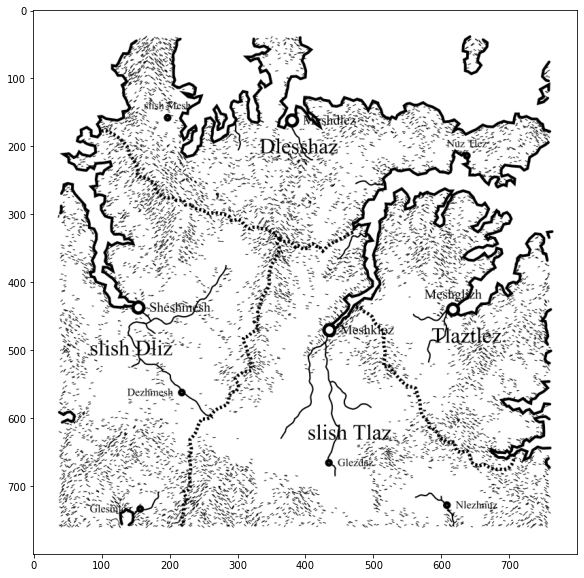

INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done


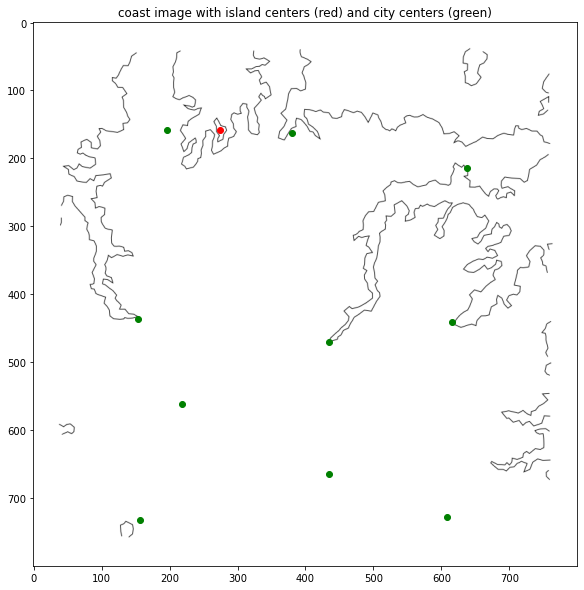

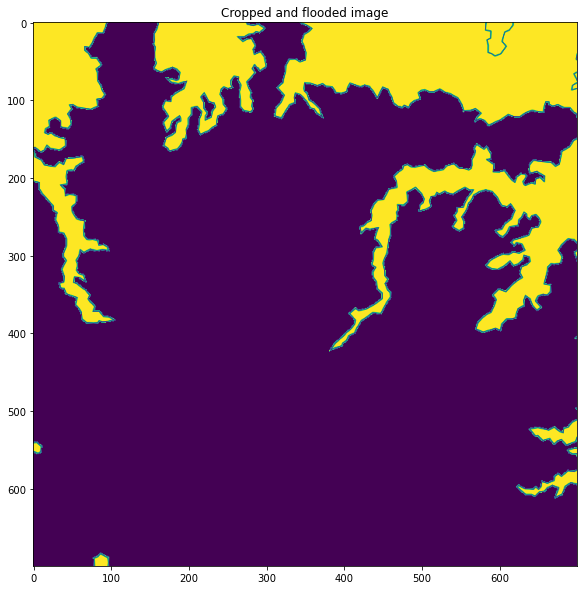

INFO:root:----Refining flooded image


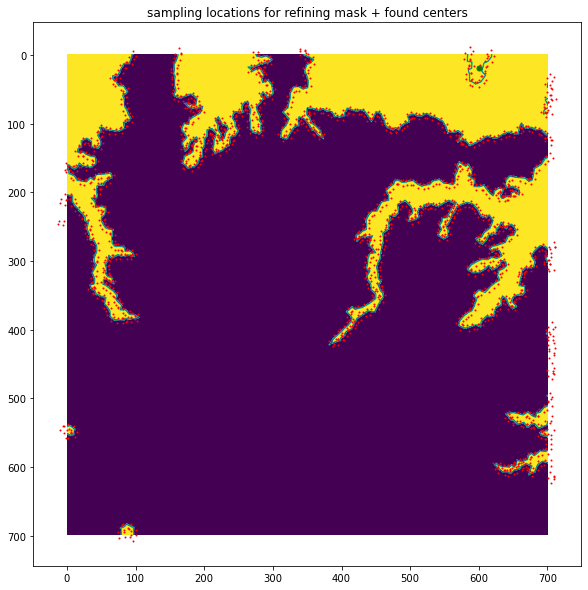

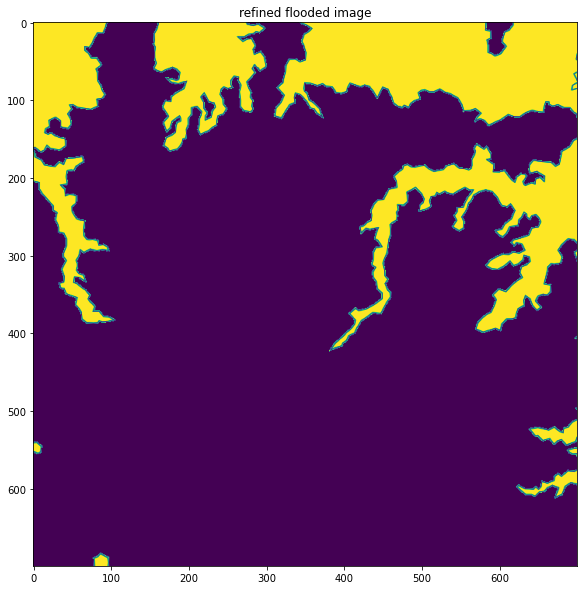

INFO:root:    \___Done
INFO:root:----Extracting rivers


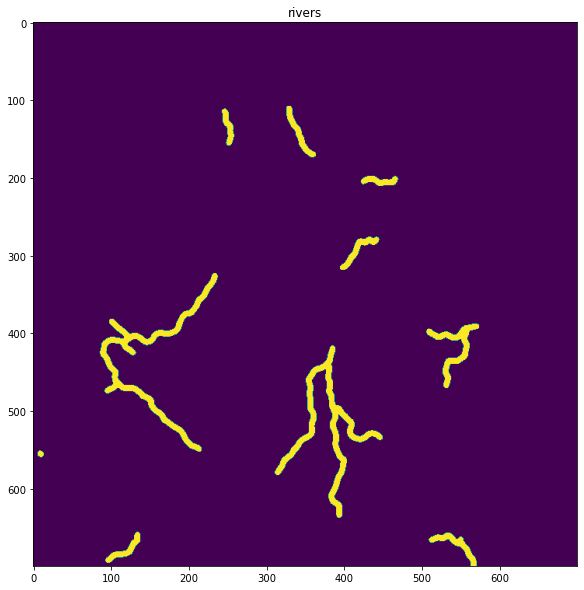

INFO:root:    \___Done
INFO:root:----Extracting rivers


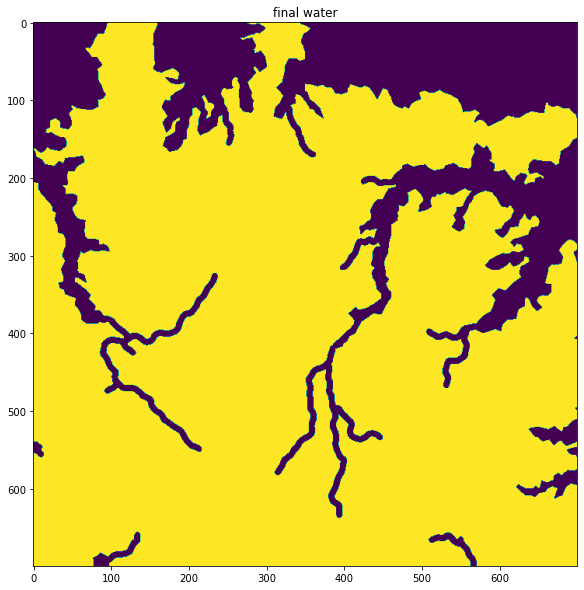

INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


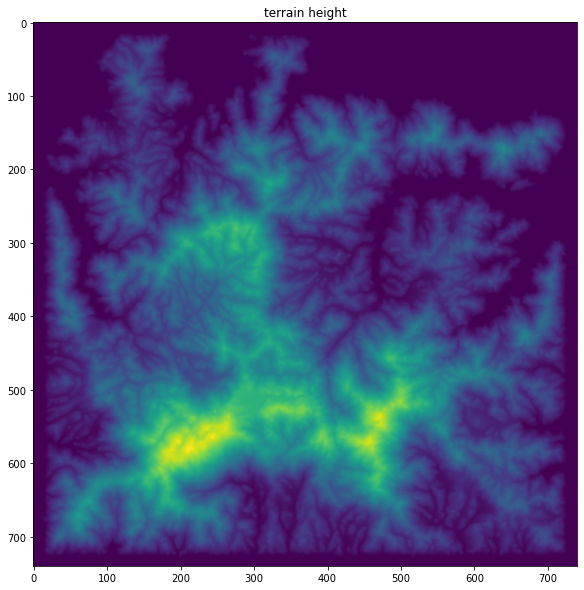

INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


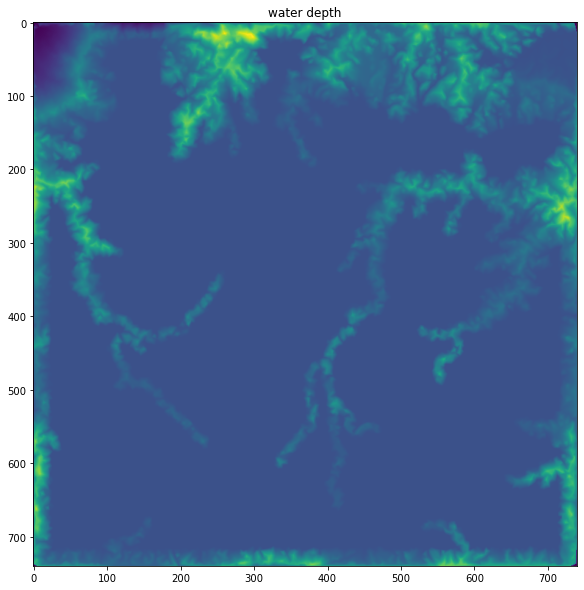

INFO:root:    \___Done
INFO:root:----Combining terrain and water heights


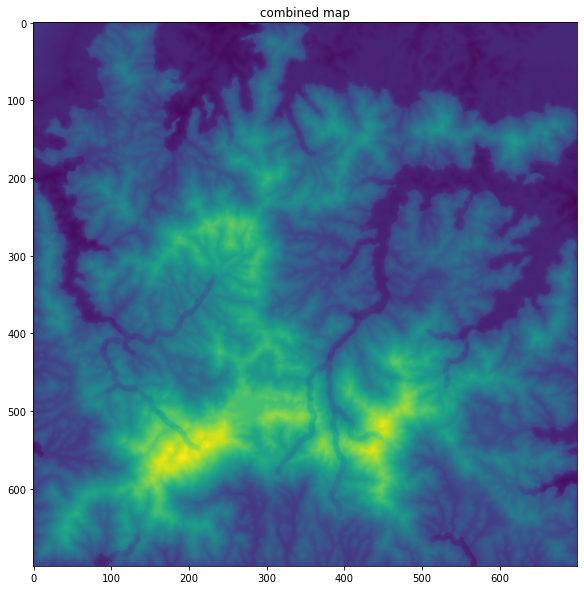

INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


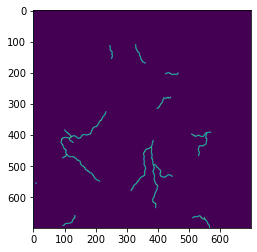

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done


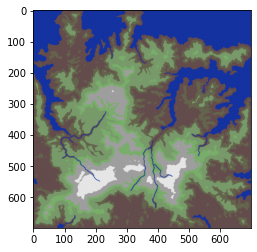

In [4]:
config = OmegaConf.load("../pipeline/config.yaml")

run_pipeline(realm_selection.value, config)

INFO:root:Processing realm number: 6316
INFO:root:Setting up extractor
INFO:root:\___Done
INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done
INFO:root:----Refining flooded image
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Combining terrain and water heights
INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


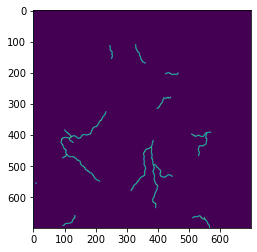

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done
INFO:root:Processing realm number: 4425
INFO:root:Setting up extractor
INFO:root:\___Done
INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done
INFO:root:----Refining flooded image
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Combining terrain and water heights
INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


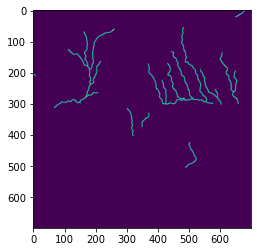

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done
INFO:root:Processing realm number: 7065
INFO:root:Setting up extractor
INFO:root:\___Done
INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done
INFO:root:----Refining flooded image
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Combining terrain and water heights
INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


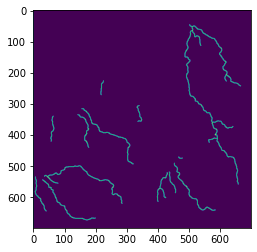

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done
INFO:root:Processing realm number: 13337
INFO:root:Setting up extractor
INFO:root:\___Done
INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done
INFO:root:----Refining flooded image
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Combining terrain and water heights
INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


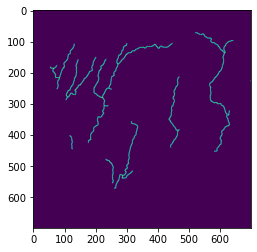

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done
INFO:root:Processing realm number: 4726
INFO:root:Setting up extractor
INFO:root:\___Done
INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done
INFO:root:----Refining flooded image
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Combining terrain and water heights
INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


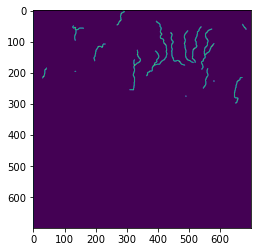

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done
INFO:root:Processing realm number: 7576
INFO:root:Setting up extractor
INFO:root:\___Done
INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done
INFO:root:----Refining flooded image
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Extracting rivers
INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


INFO:root:    \___Done
INFO:root:----Combining terrain and water heights
INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


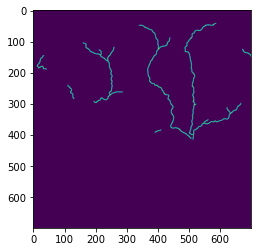

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done


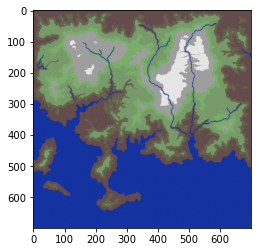

In [6]:
config = OmegaConf.load("../pipeline/config.yaml")
for svg in glob.glob("../svgs/*.svg"):
    run_pipeline(svg, config, debug=False)